# Pràctica 4 PAV 
En aquesta notebook implementem un sistema de classificació, verificació i de clustering de locutors

In [1]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = 16, 8

from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA
from sklearn import metrics

import sys
import os
import glob
import random

import librosa
import librosa.display

In [2]:
#DEFINICIO VARIABLES 
base_path = '/home/jc/pav/practica4'    #Carpeta practica 4
speecon_path = os.path.join(base_path,'audios','speecon')    #Carpeta Speecon
temp_path = os.path.join(base_path,'exports')    #Carpeta exports

### Funcións genèriques

In [3]:
def mfcc(files, n_coefs=16):
    ''' Función genérica MFCC
        Función genérica para calcular los coeficientes MFCC dada
        una lista con los paths a los audios.
        Utiliza la libreria librosa para leer el
        audio y calcular los coeficientes.
        Parametros:
        - files: lista con los ficheros a computar
        - n_coefs: int numero de coeficientes para el MFCC
        Devuelve:
        - base: np.array de tamaño Nxn_coefs con los coeficientes para cada trama'''
    
    #Inicializamos un array a ceros
    base = np.zeros((1,n_coefs))
    
    for file_audio in files:
        #Lectura del audio, remuestreamos a 8000Hz
        audio, fs = librosa.core.load(file_audio, sr=8000)
        #Calculo de los coefs
        mfcc_raw = librosa.feature.mfcc(audio, sr=fs, n_mfcc=n_coefs).T
        #Stack de la base de datos con los mfcc calculados
        base = np.vstack((base,mfcc_raw))
    
    return base[1:] #El primero no lo devolvemos porqué son los ceros de inializacion

In [5]:
def read_mfcc(path):
    ''' Reads mfcc file from person
        Parametros:
        - path: path donde leer el mfcc
    '''
    mfcc = np.loadtxt(path, delimiter=',')
    
    return mfcc

### Classificació de locutor

In [6]:
def classification_list(speecon):
    ''' Crea listas para calcular los parámetros posteriormente
        (actualmente lista todos los audios)
        Para train usamos 3/4 partes de los audios y para test 
        1/4 partes de los audios'''
    #Diccionario para contener los datos
    classification_list = dict()
    
    #Iteramos la base de datos de speecon primero bloque a bloque 
    #y luego persona a persona
    for block in os.listdir(speecon):
        block_path = os.path.join(speecon,block)
        
        for ses in os.listdir(block_path):
            ses_path = os.path.join(block_path,ses)
            
            all_files = glob.glob(f"{ses_path}/*.wav")
            
            #Para hacer el dataset cojemos 15 ficheros para entrenar y
            #5 para el test
            train_files = all_files[:15]
            test_files = all_files[-5:]
            
            #Añadimos al diccionario
            classification_list[ses[-3:]] = [train_files, test_files]
            
    return classification_list

In [7]:
def compute_mfccs(paths_dict, n_coefs):
    ''' Calculo de los MFCC
        Le pasamos el diccionario generado por classification_list. Exporta los mfcc a CSV'''
    #Paths para exportar
    train_path = os.path.join(temp_path,'class','train')
    test_path = os.path.join(temp_path,'class','test')
    
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    
    count = 0
    
    for person,paths in paths_dict.items():
        #Para calcular el modelo de la persona usamos todos los
        #audios de train
        train_mfcc = mfcc(paths[0],n_coefs)
        
        save_path = os.path.join(train_path, person[-3:]+'.mfcc')
        np.savetxt(save_path, train_mfcc, delimiter=",")
        
        #Pero para hacer el testeo usamos audio a audio
        i = 0
        for t_path in paths[1]:
            os.makedirs(os.path.join(test_path, person), exist_ok=True)
            save_path = os.path.join(test_path, person, f'audio{i}.mfcc')
      
            test_mfcc = mfcc([t_path],n_coefs)
            np.savetxt(save_path, test_mfcc, delimiter=",")
            i = i+1
        count += 1
        if not count%10 : print(f'Persona {count} calculada')
        

In [8]:
def train_gmm(n_gmms,train_path):
    ''' Entrnament de les gmm
        Retorna:
        - trained_gmm: diccionari amb els noms i les gmms
    '''
    #train_path = os.path.join(temp_path,'mfcc','train')
    files_train = glob.glob(f"{train_path}/*.mfcc")
    
    trained_gmm = dict()
    
    for mfcc_path in files_train:
        
        mfcc = read_mfcc(mfcc_path)
        
        gmm=GMM(n_gmms, n_init=2).fit(mfcc) 
        person = mfcc_path[-8:-5]
        trained_gmm[person] = gmm
        
    return trained_gmm

In [9]:
def classification(gmms, test_path):
    ''' Classificació dels audios de test_path
        Parametres:
        - gmms: llista de gmms que retorna train_gmm()
        - test_path: carpeta on hi ha els fitxers de test
        Retorna:
        - assigned: llista amb assignacions de prediccions
    '''
    trained_gmms = gmms
    assigned = list()
    test_files = glob.glob(f"{test_path}/*/*.mfcc")
    
    for traza in test_files:
        max_score = None
        predicted_person = None
        read = read_mfcc(traza)
        correct_person = traza[-15:-12]
        for key, gmm in trained_gmm.items():
            score = gmm.score(read)
            if (max_score==None) or (score>max_score):
                max_score = score
                predicted_person = key
                
        assigned.append([correct_person,predicted_person])
    return assigned

In [88]:
def precision(assigned):
    ''' Lectura dels mfcc d'una llista
    '''
    count = 0
    for prediction in assigned:
        if prediction[0] == prediction[1]:
            count = count + 1
    precision = count/len(assigned)
    
    print(f'Correct: {count}/{len(assigned)} Uncorrect: {len(assigned)-count}/{len(assigned)} Precision: {precision}')
    
    return precision

In [79]:
train_path = os.path.join(temp_path,'class','train')
test_path = os.path.join(temp_path,'class','test')

Creamos las listas para calcular las caracteristicas

In [82]:
c_list = classification_list(speecon_path)

Calculo de los MFCCs dada la lista

In [13]:
compute_mfccs(c_list, 16)

Persona 10 calculada
Persona 20 calculada
Persona 30 calculada
Persona 40 calculada
Persona 50 calculada
Persona 60 calculada
Persona 70 calculada
Persona 80 calculada
Persona 90 calculada
Persona 100 calculada
Persona 110 calculada
Persona 120 calculada
Persona 130 calculada
Persona 140 calculada
Persona 150 calculada


Entreno de las GMMs

In [84]:
trained_gmm = train_gmm(n_gmms = 6, train_path = train_path)

Clasificación de los audios

In [85]:
assigments = classification(trained_gmm, test_path)

Cálculo resultados

In [90]:
precision_v = precision(assigments)


Correct: 775/785 Uncorrect: 10/785 Precision: 0.9872611464968153


### Verificació de locutor

In [30]:
def verification_list(speecon):
    ''' Crea listas para calcular los parámetros posteriormente
        Estructura listas:
        - Hablantes entrenamiento (37.5%) : Son los audios que usamos para 
        entrenar el modelo GMM
        - Hablantes testing (12.5%) : Son unos audios de las personas de entrenamiento
        reservados para testing
        - Impostores (50%): Son las personas que no pertenecen al sistema
        Funcionamiento:
        - Partimos el dataset en dos partes, personas correctas y personas incorrectas(impostores)
        - Las personas correctas las partimos en 3/4 para entrenamiento y 1/4 parte testing
        - Guardamos el path hacia los ficheros en listas
    '''
    #Diccionario para contener los datos
    training = list()
    testing_good = list()
    impostor = list()
    #count = 0
    
    # Iteramos la base de datos de speecon primero bloque a bloque 
    # y luego persona a persona
    for block in os.listdir(speecon):
        block_path = os.path.join(speecon,block)
        
        # Listamos todos los ficheros en el Block
        ses_block = os.listdir(block_path)
        # Los desordenamos
        random.shuffle(ses_block)
        
        s = len(ses_block)
        
        # Y escojemos la mitad como usuarios buenos y la mitad como impostores
        # (Usamos floor division para obtener numeros pares)
        legit_users = ses_block[:s//2]
        impostors = ses_block[s//2:(s//2)*2]
        
        
        for user in legit_users:
            ses_path = os.path.join(block_path,user)
            
            # Obtenemos los ficheros de la persona
            all_files = glob.glob(f"{ses_path}/*.wav")
            
            # Para los users escojemos los 15 primeros ficheros (3/4) para training
            # y los ultimos 5 (1/4) para testing.
            train_files = all_files[:15]
            test_files = all_files[-5:]
            
            # Añadimos a la base de datos
            training.append(train_files)   #En los training es imortante tener una lista para cada hablante
            testing_good.extend(test_files)
        
        for imp in impostors:
            
            # Path
            ses_path = os.path.join(block_path,imp)
            
            # Para los impostores cojemos todos los ficheros para
            # testing
            all_files = glob.glob(f"{ses_path}/*.wav")
            
            # Extendemos la lista
            impostor.extend(all_files)
            
    # Devolvemos una lista con las tres listas         
    return [training, testing_good, impostor]

In [31]:
def compute_mfccs(lists, n_coefs, train_path, test_good_path, test_bad_path):
    ''' MFCCs Calculation
        Calcula los MFCCs dadas unas listas con los paths a los ficheros de cada tipo
        Parametros:
        - lists: Lista con las tres listas de ficheros
        - n_coefs: numero de coeficientes para calcular los mfccs
        - train_path: Path donde guardar los ficheros de entrenamiento
        - test_good_path: Path donde guardar los ficheros de testeo buenos
        - test_bad_path: Path donde guardar los ficheros de testeo malos (impostores)
    '''  
    
    # Comprovamos que las carpetas existan y si no las creamos
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_bad_path, exist_ok=True)
    os.makedirs(test_bad_path, exist_ok=True)
    
    training = lists[0]
    testing_good = lists[1]
    testing = lists[2]
    
    for path_list in training:
        # Para calcular el modelo de la persona usamos todos los
        # audios de train
        train_mfcc = mfcc(path_list,n_coefs)
        
        # Extraemos el nombre de la persona a partir de la path
        person = path_list[0][-10:-7]
        
        # Exportamos a csv
        save_path = os.path.join(train_path, person+'.mfcc')
        np.savetxt(save_path, train_mfcc, delimiter=",")
    
    print("Training MFCC calculated")
    
    i = 0
    for path in testing_good:
        # Extraemos el nombre de la persona a partir de la path
        person = path[-10:-7]
        
        # Creamos una carpeta para cada persona con sus audios,
        # lo hacemos así para despues facilitar su validacion
        os.makedirs(os.path.join(test_good_path, person), exist_ok=True)
        save_path = os.path.join(test_good_path, person, f'audio{i}.mfcc')
        
        # Counter
        i = i+1

        # Calculo de los mfcc
        test_mfcc = mfcc([path],n_coefs)
        
        # Exportamos a csv
        np.savetxt(save_path, test_mfcc, delimiter=",")
        
    print("Good testing MFCC calculated")
       
    i = 0
    for path in testing:
        # Extraemos el nombre de la persona a partir de la path
        person = path[-10:-7]
        
        # Creamos una carpeta para cada persona con sus audios
        os.makedirs(os.path.join(test_bad_path, person), exist_ok=True)
        save_path = os.path.join(test_bad_path, person, f'audio{i}.mfcc')

        # Counter
        i = i+1
        
        # Calculo de los mfcc
        test_mfcc = mfcc([path],n_coefs)
        
        #Exportamos a csv
        np.savetxt(save_path, test_mfcc, delimiter=",")
        
    print("Impostor MFCC calculated")
        

In [32]:
def train_gmm(n_gmms,train_path):
    ''' Entrenamiento de las GMM
        Parametros:
        - n_gmms: Numero de coeficientes a usar para calcular el modelo GMM
        - train_path: Path para leer los ficheros .csv con las MFCCs
        Devuelve:
        - trained_gmm: diccionario con los nombres y las GMMs
    '''
    # Lectura de los ficheros en la train_path
    files_train = glob.glob(f"{train_path}/*.mfcc")
    
    trained_gmm = dict()
    
    for mfcc_path in files_train:
        # Leemos los MFCCs para esa persona
        mfcc = read_mfcc(mfcc_path)
        
        # Calculo de la GMM
        gmm=GMM(n_gmms, n_init=2).fit(mfcc) 
        
        # Extracción del nombre a partir del path
        person = mfcc_path[-8:-5]
        
        # Guardamos gmm en el diccionario
        trained_gmm[person] = gmm
        
    return trained_gmm

In [61]:
def train_world_gmm(files_train, n_mfccs, n_gmms):
    base = np.zeros((1,n_mfccs))

    for mfcc_path in files_train:
        mfcc = read_mfcc(mfcc_path)
        #Stack de la base de datos con los mfcc calculados
        base = np.vstack((base,mfcc))

    gmm=GMM(n_gmms, n_init=2).fit(base)
    
    return gmm

In [76]:
def verification(trained_gmm, test_bad_path, test_good_path, world_gmm):
    ''' Verification del locutor
        Para cada hablante (una gmm por hablante) calcula la probabilidad de que 
        un conjunto de audios pertenezca a la persona. Para ese conjunto de audios
        se escojen 5 audios que pertenecen a la persona y 5 que no.
        Parametros:
        - trained_gmm: diccionario con la gmm de cada persona
        - test_bad_path: path donde encontrar los ficheros de testing malos (impostores)
        - test_good_path: path donde encontrar los ficheros de testing buenos
        Devuelve:
        - assigned: diccionario con una lista de las scores de cada audio
        las 5 primeras scores corresponden a audios de la gmm y los 5 siguientes no
    '''
    
    # Contenedor de datos
    assigned = dict()
    
    # Todos los ficheros impostores
    all_test =  glob.glob(f"{test_bad_path}/*/*.mfcc")
    # Shuffle para desordenar los ficheros y que salgan variados
    random.shuffle(all_test)
        
    # Iteramos el diccionario. key = 'persona' gmm = gmm de la persona
    for key, gmm in trained_gmm.items():
        # Obtenemos los ficheros que corresponden
        good_files = glob.glob(f"{test_good_path}/{key}/*.mfcc")
        # Cojemos 5 ficheros de testing malos (impostores),
        # como estan desordenados nos saldran ficheros de
        # personas distintas
        test_files = [all_test.pop() for i in range(0,5)]
        
        # Sanity check para comprobar que la carpeta no esta vacía
        if len(good_files)==0: continue
        
        # Lista para guardar los datos
        current_gmm = list()
        
        for path in good_files:
            # Leemos mfcc
            read = read_mfcc(path)
            # Extraemos nombre de la persona a partir del path
            person = path[42:45]
            # Calculamos la score (logscore)
            score = gmm.score(read)- world_gmm.score(read)
            # Guardamos en el contenedor
            current_gmm.append(score)
        
        for path in test_files:
            # Leemos mfcc
            read = read_mfcc(path)
            # Extraemos nombre de la persona a partir del path
            person = path[41:44]
            # Calculamos la score (logscore)
            score = gmm.score(read) - world_gmm.score(read)
            # Guardamos en el contenedor
            current_gmm.append(score)
                
        # Guardamos en el contenedor de datos
        assigned[key] = current_gmm

    return assigned
    

In [34]:
def compute_threshold(threshold, verification_dict):
    ''' Calculo de las métricas para un determinado threshold
        Parametros:
        - threshold: valor del threshold
        - verificatoin_dict: contenedor de resultados de la funcion
        verification
    '''
    # Variables
    missed = 0
    false_positive = 0
    count = 0
    
    # Iteramos todas las personas
    for key,value in verification_dict.items():
        i = 0
        # Y por todos las scores
        for l in value:
            # Como los 5 primeros son buenos, miramos si es inferior
            # al threshold. En caso afirmativo se comptabiliza como missed
            if l<threshold and i<5: missed += 1
                
            # En los 5 segundos son impostores, miramos si superan el 
            # threshold. En caso afirmativo se comptabiliza como falso positivo
            if l>threshold and i>5: false_positive += 1   
            
            # Counter de operaciones    
            i = i + 1
        
        # Cuenta total de operaciones
        count = count + i
    
    # Calculo del coste
    cost = missed + false_positive*99
    
    # Presentación de resultados
    print(f'TH: {threshold:.2f} | Missed: {missed:3}/{count} | False Positive: {false_positive:3}/{count} | Cost: {cost}')
    
    return cost

In [35]:
def find_threshold(verification_dict, starting_thr=-80, ending_thr=-50, step_thr=0.2):
    ''' Busqueda de threshold óptimo
        Calcula el threshold con el que conseguimos mejor coste.
        Definimos coste como = missed + 99*false_positive
        Parametros:
        - verification_dict: diccionario devuelto por la funcion verification()
        - starting_thr: Valor inicial de los thresholds evaluados
        - ending_thr: Valor final de los threshold evaluados
        - step_thr: Valor del step de los thresholds
        Devuelve:
        - thr: el mejor threshold para el modelo
    '''
    
    # Constantes de análisis
    cost_min = None
    thr = None
    
    # Abanico de thresholds que vamos a probar
    thr_array = np.arange(starting_thr, ending_thr, step_thr)
    
    # Iteramos todos los thresholds de thr_array
    for threshold in thr_array:
        # Usamos compute_threshold para calcular el coste del threshold
        cost = compute_threshold(threshold, verification_dict)
        
        # Miramos si el coste baja con este thr, en caso afirmativo
        # guardamos los datos
        if cost_min == None or cost_min>cost:
            cost_min = cost
            thr = threshold
        
    # Resultados finales
    print('\nFinal results:')
    compute_threshold(thr, v)
            
    return thr

In [36]:
# Definimos paths donde exportar los ficheros de las MFCCs
train_path = os.path.join(temp_path,'ver','train')
test_good_path = os.path.join(temp_path,'ver','test_good')
test_bad_path = os.path.join(temp_path,'ver','test_bad')

In [37]:
lists = verification_list(speecon_path)

In [38]:
compute_mfccs(lists, 17, train_path, test_good_path, test_bad_path)

Training MFCC calculated
Good testing MFCC calculated
Impostor MFCC calculated


In [77]:
world_gmm = train_world_gmm(files_train, n_mfccs=17, n_gmms=12)

In [39]:
trained_gmm = train_gmm(8,train_path)

In [78]:
# Si lanza error se tienen que recalcular los MFCCs
v = verification(trained_gmm, test_bad_path, test_good_path, world_gmm)

In [84]:
thr = find_threshold(v,-50,20,0.2)

TH: -50.00 | Missed:   0/740 | False Positive: 286/740 | Cost: 28314
TH: -49.80 | Missed:   0/740 | False Positive: 285/740 | Cost: 28215
TH: -49.60 | Missed:   0/740 | False Positive: 285/740 | Cost: 28215
TH: -49.40 | Missed:   0/740 | False Positive: 285/740 | Cost: 28215
TH: -49.20 | Missed:   0/740 | False Positive: 284/740 | Cost: 28116
TH: -49.00 | Missed:   0/740 | False Positive: 284/740 | Cost: 28116
TH: -48.80 | Missed:   0/740 | False Positive: 283/740 | Cost: 28017
TH: -48.60 | Missed:   0/740 | False Positive: 281/740 | Cost: 27819
TH: -48.40 | Missed:   0/740 | False Positive: 281/740 | Cost: 27819
TH: -48.20 | Missed:   0/740 | False Positive: 281/740 | Cost: 27819
TH: -48.00 | Missed:   0/740 | False Positive: 281/740 | Cost: 27819
TH: -47.80 | Missed:   0/740 | False Positive: 280/740 | Cost: 27720
TH: -47.60 | Missed:   0/740 | False Positive: 280/740 | Cost: 27720
TH: -47.40 | Missed:   0/740 | False Positive: 280/740 | Cost: 27720
TH: -47.20 | Missed:   0/740 | Fal

### Clustering de locutors

In [10]:
def compute_mfccs(audiolist,n_coefs):
    ''' Calculo de los MFFCs (contenemos todos los datos en memoria)'''
    # Contenedor de datos
    audio_mfcc = list()
    
    # Iteramos todos los audios de la lista
    for audio in audiolist:
        audio_mfcc.append(mfcc([audio],n_coefs))
    return audio_mfcc

In [11]:
def compute_gmms(mfcc_list,n_gmms):
    ''' Calculo de las GMMs'''
    # Contenedor de datos
    audio_gmm = list()
    
    # Iteramos todas las mfcc de la lista
    for mfcc_a in mfcc_list:
        gmm=GMM(n_gmms, n_init=2).fit(mfcc_a) 
        audio_gmm.append(gmm)
    
    return audio_gmm

In [12]:
def compute_matrix(mfcc_list,gmm_list):
    ''' Calculo de la matriz
        Calculamos la score de cada audio para cada gmm, 
        con esto obtenemos una matriz (NxN)
    '''
    
    # Obtenemos el tamaño de la lista de mfcc
    l = len(mfcc_list)
    # Inicializamos matriz a ceros
    data = np.zeros([l,l])

    # Iteramos la matriz y la llenamos con los datos
    for i in range(0,l):
        for j in range(0,l):
            # Calculo de la score del audio con la gmm en concreto
            data[i,j] = gmm_list[i].score(mfcc_list[j]) 
    
        #data[i,:] = data[i,:]/(-sum(data[i,:])/l)
    
    return data

In [13]:
def plot_data(data):
    ''' Plot matriz imshow()'''
    plt.figure(figsize=(10,10))
    plt.imshow(data);
    plt.colorbar()
    plt.show()

In [14]:
def update_mfcc(pos, mfcc_list):
    ''' Actualización del contenedor de MFFCs
        Concatena los dos segmentos que unimos y saca
        de la lista el segundo componente'''
    mfcc_list[pos[0]] = np.concatenate((mfcc_list[pos[0]],mfcc_list[pos[1]]))
    mfcc_list.pop(pos[1])
    
    return mfcc_list

In [15]:
def find_max(data,n):
    ''' Busqueda del maximo en la matriz data
        Esta función busca el valor máximo en la matriz para 
        juntar los datos en la siguiente iteración.
        Definimos unas normas para optimizar el resultado, las dos 
        más importantes són; 
        - Si es una diagonal, indice i y j igual no
        lo contamos ya que es el mismo audio. 
        - No se pueden juntar dos grupos grandes (6>) de audios, 
        así evitamos crear un grupo gigante que contenga todos los audios.
        Parametros: 
        - data: Matriz de datos
        - n: Lista con los grupos que se van formando
        Devuelve:
        - Pos: Lista de dos valores que contiene el indice i y j del valor
        máximo, ordenado en orden ascendente.
    '''
    # Valor que comparamos
    m = None
    # Variable de la posición
    pos = None
    
    # Lista con los tamaños de los clusters
    sizes = [len(n[c]) for c in range(0,len(n))]
    # Lista con los tamaños de los clusters en orden ascendente
    sorted_sizes = sorted(sizes,reverse=True)
    
    # Iteramos la matriz de datos
    for i in range(0,data.shape[0]):
        for j in range(0,data.shape[1]):
            
            # Batería de filtros
            if i==j : break
            #if ((sizes[i]>2) or (sizes[j]>2)) and (((sizes[i]*1.2)<sizes[j]) or (sizes[i]>(1.2*sizes[j]))): break
            #if (i==no) or (j==no): break
            #if (max(sizes)>6) and (i==sizes.index(sorted_sizes[0]) and j==sizes.index(sorted_sizes[1])): 
                #print(i,sizes.index(sorted_sizes[0]),j,sizes.index(sorted_sizes[1]))
                #break
            if (max(sizes)>6) and (((i==0) and (j==1)) or ((i==1) and (j==0))): break
            #if (i==sizes.index(sorted_sizes[0])) and (j==sizes.index(sorted_sizes[1])): 
            #    print(i,sizes.index(sorted_sizes[0]),j,sizes.index(sorted_sizes[1]))
            #    break
            
            # Miramos si encontramos un máximo
            if (m==None) or (m<data[i,j]):
                m = data[i,j]
                pos = [i,j]
    
    # Devolvemos los datos
    return [min(pos),max(pos)]

In [25]:
def clustering(person1,person2,show=True):
    ''' Clustering de los audios'''
    # Lectura de los ficheros a detectar
    audio1 = glob.glob(person1+'/*.wav')
    audio2 = glob.glob(person2+'/*.wav')
    audio1.extend(audio2)
    audiolist = audio1

    # Inicialización de los datos
    mfcc_list = compute_mfccs(audiolist,6)
    gmm_list = compute_gmms(mfcc_list,2)
    data = compute_matrix(mfcc_list,gmm_list)

    # Presentación de los datos iniciales
    if show:
        print('Matriz de datos iniciales:')
        plot_data(data)

    # Inicialización de los clusters
    # Usamos una lista conteniendo una lista con su 
    # propio indice. Luego extendemos la lista con cada
    # actualización del mapa. Finalmente resultan dos 
    # listas que representan los dos clusters finales
    n = [[i] for i in range(0,40)]

    for i in range(0,38):
        # Encontramos el máximo en la matriz
        pos = find_max(data,n)

        # Debug de datos
        #print(pos)
        #print(n)

        # Actualización de los datos de la lista de clusters
        n[pos[0]].extend(n[pos[1]])
        n.pop(pos[1])

        # Actualización de los datos en la lista de MFCCs
        mfcc_list = update_mfcc(pos, mfcc_list)

        # Calculo de las gmms actualizadas
        gmm_list = compute_gmms(mfcc_list,2)

        # Calculo de la matriz de esta iteración
        data = compute_matrix(mfcc_list,gmm_list)

        # Visualización de los datos
        #plot_data(data)

    print('Clusters finales:')
    print(n)

    # Evaluación de los datos
    n00 = (np.array(n[0])>=20)
    n01 = (np.array(n[0])<=19)
    n10 = (np.array(n[1])>=20)
    n11 = (np.array(n[1])<=19)

    if sum(n00)>sum(n01):
        speaker1 = np.array(n[1])
        speaker2 = np.array(n[0])
    else:
        speaker1 = np.array(n[0])
        speaker2 = np.array(n[1])

    precision1 = sum(speaker1<=19)/speaker1.shape[0]
    recall1 = sum(speaker1<=19)/20
    if show:
        print(f'\nPrecision: {precision1} Recall: {recall1}')

    precision2 = sum(speaker2>=20)/speaker2.shape[0]
    recall2 = sum(speaker2>=20)/20
    if show:
        print(f'\nPrecision: {precision2} Recall: {recall2}')

    p_total = (precision1+precision2)/2
    r_total = (recall1+recall2)/2
    
    print(f'\nValores finales: {p_total} {r_total}\n')

    return [p_total,r_total]

Matriz de datos iniciales:


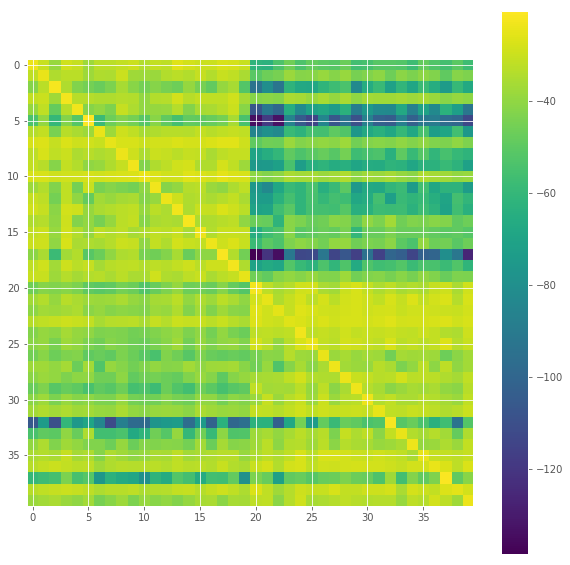

Clusters finales:
[[0, 1, 7, 3, 5, 9, 10, 8, 14, 16, 18, 6, 15, 19, 4, 17, 12], [2, 11, 13, 20, 22, 21, 24, 32, 37, 38, 23, 25, 28, 29, 36, 26, 35, 27, 30, 31, 34, 39, 33]]

Precision: 1.0 Recall: 0.85

Precision: 0.8695652173913043 Recall: 1.0

Valores finales: 0.9347826086956521 0.925



[0.9347826086956521, 0.925]

In [26]:
# Definición de las paths a las personas que vamos a usar en el análisis
person1 = '/home/jc/pav/practica4/audios/speecon/BLOCK00/SES001'
person2 = '/home/jc/pav/practica4/audios/speecon/BLOCK18/SES185'

clustering(person1,person2)

Càlcul resultats. Fem 10 realitzacions del clustering amb persones diferents i calculem la mitjana de la precision i del recall

In [35]:
# Lectura de los ficheros de speecon
ficheros = glob.glob('/home/jc/pav/practica4/audios/speecon/*/*')

# Variables para calcular metricas
precision = 0
recall = 0

# Iteramos 10 veces (n experimentos)
for count in range(0,10):
    # Realizamos una muestra de los ficheros
    paths = random.sample(ficheros,k=2)
    # Guardamos las metricas
    metrics = clustering(paths[0], paths[1], show=False)
    precision += metrics[0]
    recall += metrics[1]

# Métricas finales    
precision = precision/count
recall = recall/count

print(f'\nPrecision: {precision} Recall: {recall}')

Clusters finales:
[[0, 12, 5, 13, 16, 4, 8, 11, 19, 3, 7, 18, 10, 17, 9, 20, 32, 29, 37, 21, 23, 26, 24, 34, 35, 25, 30, 38, 33, 36, 39, 31, 28, 22, 27], [1, 6, 2, 15, 14]]

Valores finales: 0.7857142857142857 0.625

Clusters finales:
[[0, 2, 4, 16, 20, 23, 22, 36, 38, 21, 25, 34, 37, 26, 27, 5, 7, 12, 17, 18, 28, 30, 31, 29, 32, 35, 24, 33, 39], [1, 10, 11, 6, 15, 3, 8, 13, 14, 19, 9]]

Valores finales: 0.8448275862068966 0.775

Clusters finales:
[[0, 12, 9, 17, 1, 3, 6, 4, 14, 15, 5, 10, 18, 13, 16, 19, 11, 22, 7], [2, 8, 20, 21, 24, 35, 25, 36, 29, 33, 26, 31, 34, 39, 30, 32, 23, 27, 28, 37, 38]]

Valores finales: 0.9260651629072681 0.925

Clusters finales:
[[0, 15, 3, 9, 14, 8, 12, 13, 5, 11, 19, 30, 4, 17, 2, 7], [1, 6, 10, 18, 21, 34, 23, 32, 24, 35, 29, 33, 39, 22, 25, 27, 26, 20, 16, 37, 31, 38, 28, 36]]

Valores finales: 0.8645833333333333 0.85

Clusters finales:
[[0, 4, 10, 19, 12, 14, 2, 8, 11, 6, 16, 18, 3, 5, 15, 9, 20, 22, 25, 26, 27, 28, 33, 34, 24, 32, 30, 31, 35, 38, 3

### Gràfiques memòria

In [56]:
rcParams['figure.figsize'] = 10, 8

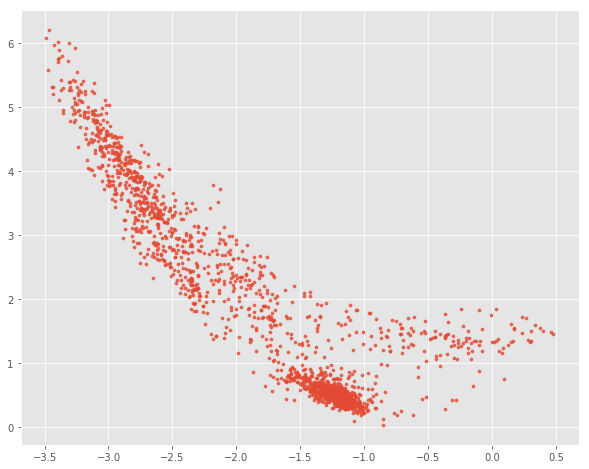

In [61]:
# Plot LPC
audio_path = base_path + '/audios/ona.wav'
lpc1 = np.loadtxt('./exports/col2.pot')
lpc2 = np.loadtxt('./exports/col3.pot')
plt.scatter(col1,col2, alpha=0.8, s=10)

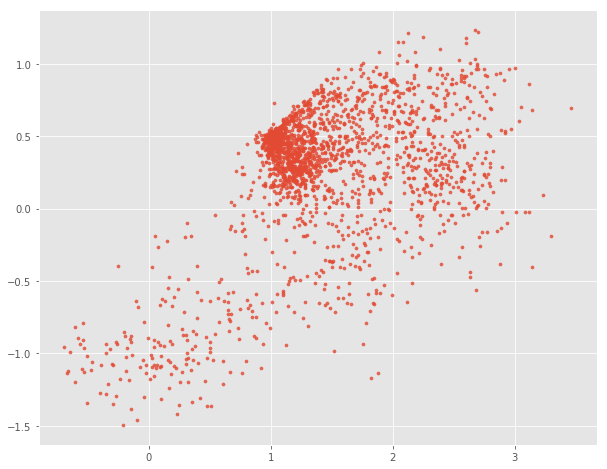

In [64]:
# Plot LPCC
audio_path = base_path + '/audios/ona.wav'
lpcc1 = np.loadtxt('./exports/col2.pot')
lpcc2 = np.loadtxt('./exports/col3.pot')
plt.scatter(lpcc1,lpcc2, alpha=0.8, s=10)

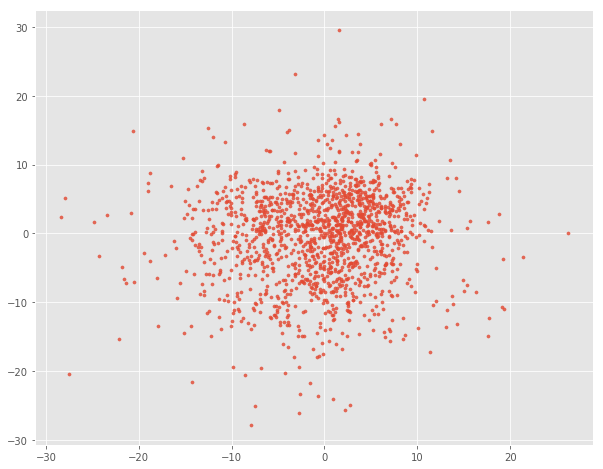

In [63]:
# Plot MFCC
audio_path = base_path + '/audios/ona.wav'
mfcc1 = np.loadtxt('./exports/col2.pot')
mfcc2 = np.loadtxt('./exports/col3.pot')
plt.scatter(mfcc1,mfcc2, alpha=0.8, s=10)

### PCA dels MFCC

In [9]:
def make_pca(person):
    pca = PCA(n_components=3)
    pca.fit(person.T)
    return pca.components_

In [ ]:
read_list[]

Plot dels PCA en dos dimensions de 6 locutors diferents. Aquí s'explica perqué en clusterització si utilitzem un model GMM de 2 dimensions funciona especialment bé, en el PCA s'observen dos regions on els punts podrien modelarse com una gaussiana.

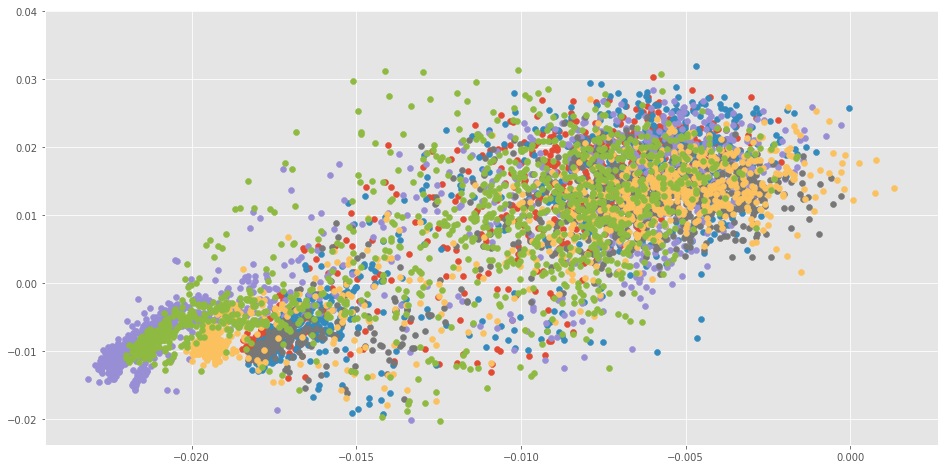

In [22]:
for i in range(0,len(read_list)+1):
    plot = pc[1:,pc[0,:] == i]
    plt.scatter(plot[0],plot[1])

### Càlcul de les GMM i mètriques d'evaluació
Per a calcular les GMM utilitzem la llibreria scikit learn que té una implementació fet i també el càlcul de mètriques per a l'evaluació

In [23]:
def SelBest(arr:list, X:int)->list:
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [30]:
def make_clusters(db):
    n_clusters=np.arange(2, 12)
    metrics_dict = {'bic':[[],[]], 'aic':[[],[]], 'sil':[[],[]]}
    iterations=10
    for n in n_clusters:
        print(f'Calculant amb {n} clusters!')
        tmp_bic=[]
        tmp_aic=[]
        tmp_sil=[]
        for _ in range(iterations):
            gmm=GMM(n, n_init=2).fit(db[:,:-1]) 
            tmp_bic.append(gmm.bic(db[:,:-1]))
            tmp_aic.append(gmm.aic(db[:,:-1]))
            
            labels=gmm.predict(db[:,:-1])
            sil=metrics.silhouette_score(db[:,:-1], labels, metric='euclidean')
            tmp_sil.append(sil)

        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
        err=np.std(tmp_bic)
        metrics_dict['bic'][0].append(val)
        metrics_dict['bic'][1].append(err)

        val=np.mean(SelBest(np.array(tmp_aic), int(iterations/5)))
        err=np.std(tmp_aic)
        metrics_dict['aic'][0].append(val)
        metrics_dict['aic'][1].append(err)
        
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        metrics_dict['sil'][0].append(val)
        metrics_dict['sil'][1].append(err)
        
    return metrics_dict

In [31]:
metrics = make_clusters(reduced_db)

Calculant amb 2 clusters!
Calculant amb 3 clusters!
Calculant amb 4 clusters!
Calculant amb 5 clusters!
Calculant amb 6 clusters!
Calculant amb 7 clusters!
Calculant amb 8 clusters!
Calculant amb 9 clusters!
Calculant amb 10 clusters!
Calculant amb 11 clusters!


### Anàlisis del nombre òptim de clusters
Per a trobar el nombre òptim de clusters realitzem plots de les mètriques d'evaluació i busquem un punt on sembli bon resultat. Com més baixa puntuació millor.

In [42]:
def plot_bic():
    n_clusters=np.arange(2, 12)
    plt.errorbar(n_clusters,metrics['bic'][0], yerr=metrics['bic'][1], label='BIC')
    plt.errorbar(n_clusters,metrics['aic'][0], yerr=metrics['aic'][1], label='AIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters")
    plt.ylabel("Score")
    plt.legend()

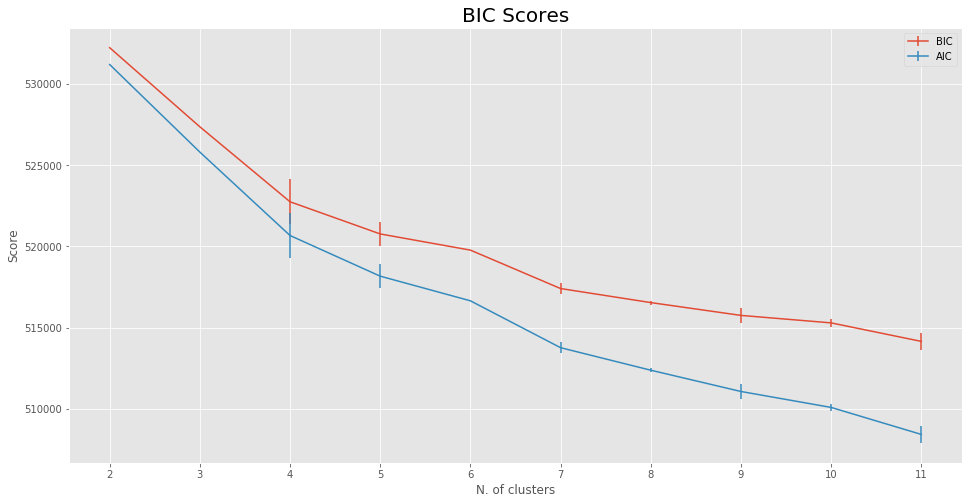

In [43]:
plot_bic()

In [44]:
def plot_grad_bic():
    plt.errorbar(n_clusters, np.gradient(metrics['bic'][0]), yerr=metrics['bic'][1], label='BIC')
    plt.errorbar(n_clusters, np.gradient(metrics['aic'][0]), yerr=metrics['aic'][1], label='AIC')
    plt.title("Gradient of BIC Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters")
    plt.ylabel("grad(BIC)")
    plt.legend()

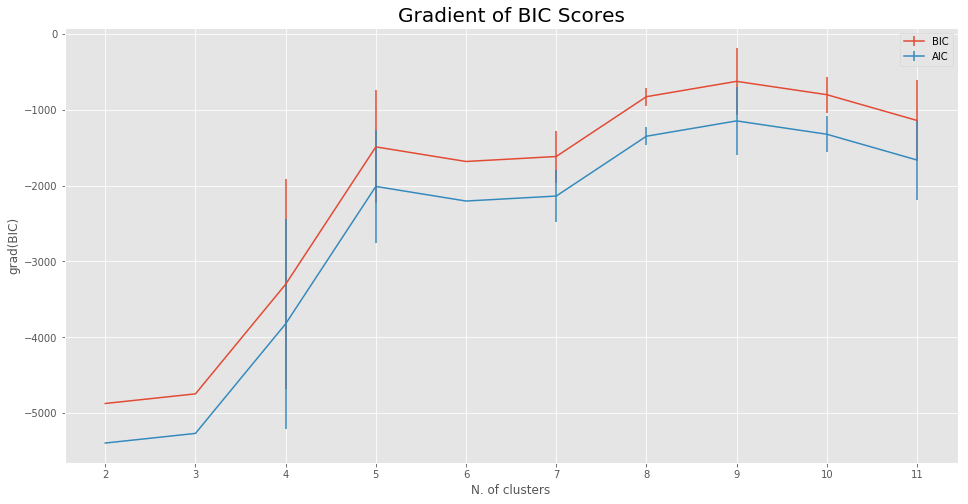

In [45]:
plot_grad_bic()